In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41227")
client

<Client: 'tcp://127.0.0.1:41227' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
import xrft
import s3fs
import gsw

import glob

import gcm_filters

import os.path as op

from xeofs.models import EOF
from pydmd import DMD, BOPDMD, MrDMD
from pydmd.mrcosts import mrCOSTS
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_eigs, plot_summary

import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sdir = '/tank/spectre/tuchida/DMD/'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
entries = list(cat._entries.keys())
entries

['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32']

In [6]:
# hycom01w = cat.HYCOM50(region='1_GS', datatype='surf', season='fma', decode_times=False
#                       ).to_dask().isel(lat=slice(240,490),lon=slice(-280,None))
hycom01s = cat.HYCOM50(region='1_GS', datatype='surf', season='aso', decode_times=False
                      ).to_dask()

hycom01s

<xarray.Dataset>
Dimensions:    (lat: 615, lon: 503, time: 2208)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2201 2202 2203 2204 2205 2206 2207
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    ssh        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sss        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    tauewd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    taunwd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    uu1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    vv1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>

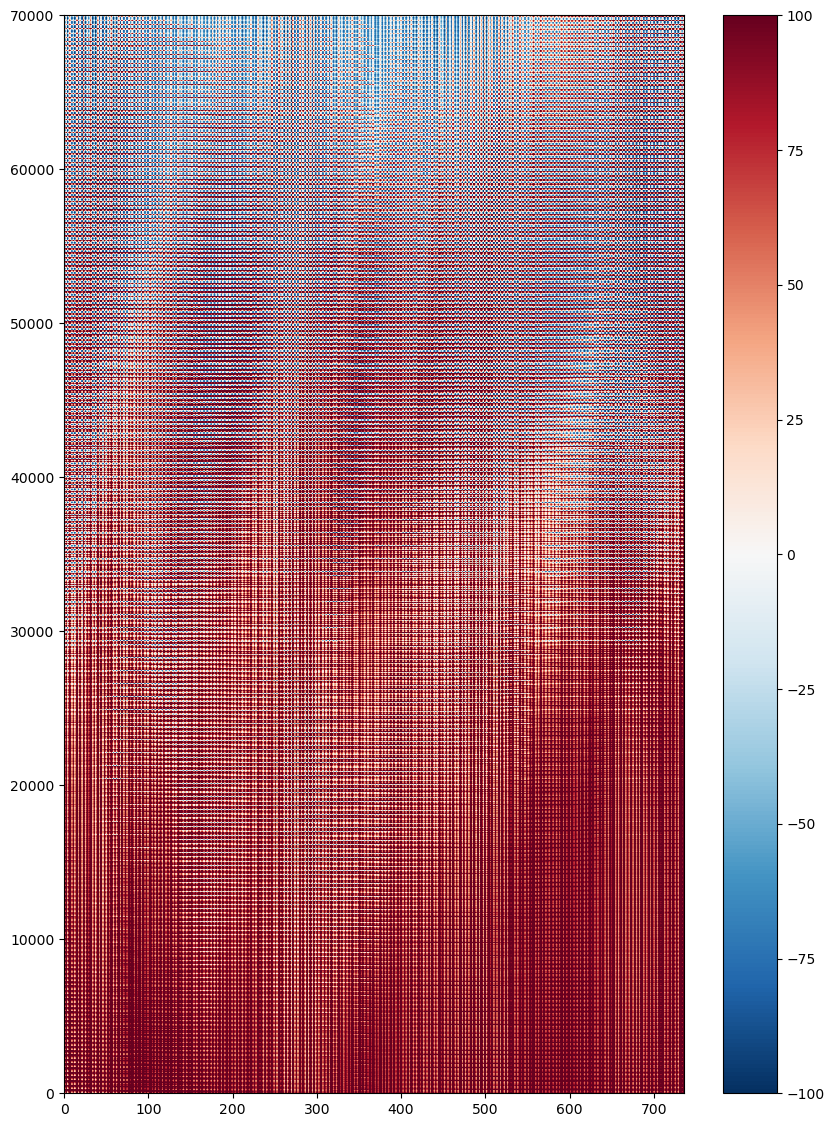

In [10]:
fig, ax = plt.subplots(figsize=(10,14))
cs = ax.pcolormesh(hycom01s.ssh.isel(lat=slice(240,490),lon=slice(-280,None),
                                time=np.arange(0,len(hycom01s.time),3),
                               ).stack(z=("lat","lon")).T.values, 
              rasterized=True, vmin=-1e2, vmax=1e2, cmap='RdBu_r')
# for c in cs.collections:
#     c.set_rasterized(True)
fig.colorbar(cs)

In [7]:
hycom50_grids = xr.open_dataset('/tank/spectre/tuchida/SWOT/Models/HYCOM50/HYCOM50_grid_GS_all.nc'
                               )
hycom50_grids

<xarray.Dataset>
Dimensions:  (lat: 615, lon: 503)
Dimensions without coordinates: lat, lon
Data variables: (12/20)
    plat     (lat, lon) float64 ...
    plon     (lat, lon) float64 ...
    qlat     (lat, lon) float64 ...
    qlon     (lat, lon) float64 ...
    ulat     (lat, lon) float64 ...
    ulon     (lat, lon) float64 ...
    ...       ...
    vscx     (lat, lon) float64 ...
    vscy     (lat, lon) float64 ...
    pang     (lat, lon) float64 ...
    cori     (lat, lon) float64 ...
    pasp     (lat, lon) float64 ...
    depth    (lat, lon) float64 ...

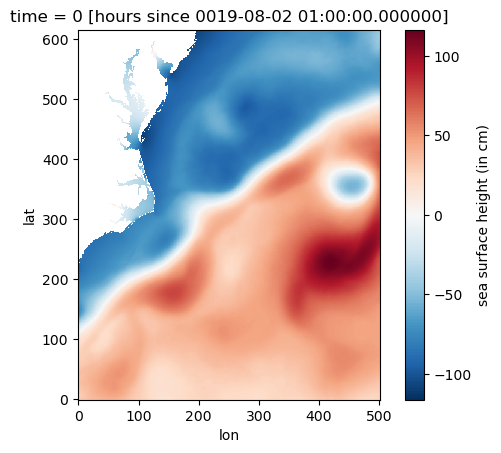

In [8]:
SSH = (hycom01s.ssh - hycom01s.ssh.mean(['lat','lon']))
# SST = (hycom01s.sst - hycom01s.sst.mean(['lat','lon']))
# SSS = (hycom01s.sss - hycom01s.sss.mean(['lat','lon']))
SSU = hycom01s.uu1
SSV = hycom01s.vv1

fig, ax = plt.subplots()
SSH.isel(time=0).plot(rasterized=True)
ax.set_aspect('equal')
plt.show()

# ampH = np.abs(SSH).mean().compute()
# ampT = np.abs(SST).mean().compute()
# ampS = np.abs(SSS).mean().compute()
# print(ampH.values, ampT.values, ampS.values)

In [27]:
ssh = SSH.copy()
hycom_copy = hycom01s.drop(['ssh','sst','sss']).copy()
Ny = len(hycom50_grids.lat)
Nx = len(hycom50_grids.lon)

## Make metadata C-grid again ##

hycom_copy['ssh'] = xr.DataArray(ssh.data, dims=['time','lat','lon'],
                                 coords={'time':hycom01s.time,
                                         'lat':hycom01s.lat,'lon':hycom01s.lon}
                                )
hycom_copy.coords['lonG'] = ('lonG', np.arange(-.5,Nx-.5,1))
hycom_copy.coords['latG'] = ('latG', np.arange(-.5,Ny-.5,1))

coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'},
       }

grid = Grid(hycom_copy, coords=coords, periodic=[])

import gsw

dxF = xr.DataArray(hycom50_grids.pscx.data, dims=hycom_copy.ssh.isel(time=0).dims, 
                   coords=hycom_copy.ssh.isel(time=0).coords
                  ).reset_coords(drop=True)
dyF = xr.DataArray(hycom50_grids.pscy.data, dims=hycom_copy.ssh.isel(time=0).dims, 
                   coords=hycom_copy.ssh.isel(time=0).coords
                  ).reset_coords(drop=True)
dxC = xr.DataArray(hycom50_grids.uscx.data, dims=['lat','lonG'],
                   coords={'lat':hycom_copy.lat,'lonG':hycom_copy.lonG})
dyC = xr.DataArray(hycom50_grids.vscy, dims=['latG','lon'],
                   coords={'latG':hycom_copy.latG,'lon':hycom_copy.lon})
dxG = xr.DataArray(hycom50_grids.vscx, dims=['latG','lon'],
                   coords={'latG':hycom_copy.latG,'lon':hycom_copy.lon})
dyG = xr.DataArray(hycom50_grids.uscy, dims=['lat','lonG'],
                   coords={'lat':hycom_copy.lat,'lonG':hycom_copy.lonG})

hycom_copy.coords['dxF'] = dxF
hycom_copy.coords['dyF'] = dyF
hycom_copy.coords['dxC'] = dxC
hycom_copy.coords['dyC'] = dyC
hycom_copy.coords['dxG'] = dxG
hycom_copy.coords['dyG'] = dyG

mask = ~np.ma.masked_invalid(hycom_copy.ssh.isel(time=0)).mask

wet_mask = xr.DataArray(np.zeros((len(hycom_copy.lat),len(hycom_copy.lon))),
                        dims=['lat','lon'],
                        coords={'lat':hycom_copy.lat,'lon':hycom_copy.lon}
           )
wet_mask[1:-1,1:-1] = mask[1:-1,1:-1].astype(np.float64)
wet_mask = wet_mask.chunk({'lat':100,'lon':100})

area = (hycom_copy.dxF * hycom_copy.dyF)

dxw = xr.DataArray(hycom_copy.dxC.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(hycom_copy.dyG.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(hycom_copy.dxG.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(hycom_copy.dyC.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge

dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values

kappa_w = xr.ones_like(wet_mask)
kappa_s = xr.ones_like(wet_mask)

filter_scale = 20_000
filt_mask = wet_mask.chunk({'lat':-1,'lon':-1}).reset_coords(drop=True)

filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
            'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
            'area': area.chunk({'lat':-1,'lon':-1}), 
            'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 
            'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
        }
    )

SSHm = filter.apply(hycom_copy.ssh.chunk({'lat':-1,'lon':-1}), 
                    dims=['lat','lon']).reset_coords(drop=True)

SSHm.to_dataset(name='ssh').to_zarr(
    '/tank/spectre/tuchida/SWOT/Models/HYCOM50/SSH_20km.zarr', 
    mode='w')

<xarray.DataArray 'ssh' (time: 2208, lat: 615, lon: 503)>
dask.array<transpose, shape=(2208, 615, 503), dtype=float32, chunksize=(24, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 2201 2202 2203 2204 2205 2206 2207
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502

In [11]:
u = SSU.copy()
v = SSV.copy()
hycom_copy = hycom01s.drop(['ssh','sst','sss','uu1','vv1']).copy()
Ny = len(hycom50_grids.lat)
Nx = len(hycom50_grids.lon)

## Make metadata C-grid again ##

hycom_copy['u'] = xr.DataArray(u.data, dims=['time','lat','lonG'],
                               coords={'time':hycom01s.time,
                                       'lat':hycom01s.lat,
                                       'lonG':np.arange(-.5,Nx-.5,1)}
                              ).reset_coords(drop=True)
hycom_copy['v'] = xr.DataArray(v.data, dims=['time','latG','lon'],
                               coords={'time':hycom01s.time,
                                       'latG':np.arange(-.5,Ny-.5,1),
                                       'lon':hycom01s.lon}
                              ).reset_coords(drop=True)

coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'},
       }

grid = Grid(hycom_copy, coords=coords, periodic=[])

mask = xr.DataArray(~np.ma.masked_invalid(hycom01s.ssh.isel(time=0)).mask,
                    dims=hycom01s.ssh.isel(time=0).dims,
                    coords=hycom01s.ssh.isel(time=0).coords
                   ).reset_coords(drop=True)
# grid info centered at T-points
wet_mask_t = mask.copy()
wet_mask_t[dict(lon=-1)] = 0.
wet_mask_t[dict(lon=0)] = 0.
wet_mask_t[dict(lat=-1)] = 0.
wet_mask_t[dict(lat=0)] = 0.

mask = xr.DataArray(~np.ma.masked_invalid(grid.interp(grid.interp(hycom01s.ssh,
                                                                  'X',boundary='extend'
                                                                 ),'Y',boundary='extend'
                                                     ).isel(time=0)).mask,
                    dims=hycom01s.ssh.isel(time=0).dims,
                    coords=hycom01s.ssh.isel(time=0).coords
                   ).reset_coords(drop=True)
# grid info centered at vorticity points
wet_mask_q = mask.copy()
wet_mask_q[dict(lon=-1)] = 0.
wet_mask_q[dict(lon=0)] = 0.
wet_mask_q[dict(lat=-1)] = 0.
wet_mask_q[dict(lat=0)] = 0.

# grid info centered at T-points
dxT = xr.DataArray(hycom50_grids.pscx.data, dims=hycom01s.ssh.isel(time=0).dims, 
                   coords=hycom01s.ssh.isel(time=0).coords
                  ).reset_coords(drop=True)
dyT = xr.DataArray(hycom50_grids.pscy.data, dims=hycom01s.ssh.isel(time=0).dims, 
                   coords=hycom01s.ssh.isel(time=0).coords
                  ).reset_coords(drop=True)
# grid info centered at U-points
dxCu = xr.DataArray(hycom50_grids.uscx.data, dims=['lat','lonG'],
                    coords={'lat':hycom_copy.lat,'lonG':hycom_copy.lonG}
                   ).swap_dims({"lonG": "lon"}).reset_coords(drop=True)
dyCu = xr.DataArray(hycom50_grids.uscy, dims=['lat','lonG'],
                    coords={'lat':hycom_copy.lat,'lonG':hycom_copy.lonG}
                   ).swap_dims({"lonG": "lon"}).reset_coords(drop=True)
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = xr.DataArray(hycom50_grids.vscx, dims=['latG','lon'],
                    coords={'latG':hycom_copy.latG,'lon':hycom_copy.lon}
                   ).swap_dims({"latG": "lat"}).reset_coords(drop=True)
dyCv = xr.DataArray(hycom50_grids.vscy, dims=['latG','lon'],
                    coords={'latG':hycom_copy.latG,'lon':hycom_copy.lon}
                   ).swap_dims({"latG": "lat"}).reset_coords(drop=True)
area_v = dxCv * dyCv
# grid info centered at Q-points
dxBu = xr.DataArray(hycom50_grids.qscx, dims=['latG','lonG'],
                    coords={'latG':hycom_copy.latG,'lonG':hycom_copy.lonG}
                   ).swap_dims({"lonG": "lon", "latG": "lat"}).reset_coords(drop=True)
dyBu = xr.DataArray(hycom50_grids.qscy, dims=['latG','lonG'],
                    coords={'latG':hycom_copy.latG,'lonG':hycom_copy.lonG}
                   ).swap_dims({"lonG": "lon", "latG": "lat"}).reset_coords(drop=True)

dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values

kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

filter_scale = 10_000

filter_visc = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.VECTOR_C_GRID,
        grid_vars={
            'wet_mask_t': wet_mask_t.chunk({'lat':-1,'lon':-1}), 
            'wet_mask_q': wet_mask_q.chunk({'lat':-1,'lon':-1}),
            'dxT': dxT.chunk({'lat':-1,'lon':-1}), 
            'dyT': dyT.chunk({'lat':-1,'lon':-1}), 
            'dxCu': dxCu.chunk({'lat':-1,'lon':-1}), 
            'dyCu': dyCu.chunk({'lat':-1,'lon':-1}), 
            'area_u': area_u.chunk({'lat':-1,'lon':-1}), 
            'dxCv': dxCv.chunk({'lat':-1,'lon':-1}), 
            'dyCv': dyCv.chunk({'lat':-1,'lon':-1}), 
            'area_v': area_v.chunk({'lat':-1,'lon':-1}),
            'dxBu': dxBu.chunk({'lat':-1,'lon':-1}), 
            'dyBu': dyBu.chunk({'lat':-1,'lon':-1}),
            'kappa_iso': kappa_iso.chunk({'lat':-1,'lon':-1}), 
            'kappa_aniso': kappa_aniso.chunk({'lat':-1,'lon':-1})
        }
    )

ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
ds_tmp['u'] = hycom_copy.u
ds_tmp['v'] = hycom_copy.v
ds_tmp['u'] = ds_tmp['u'].swap_dims({'lonG':'lon'})
ds_tmp['v'] = ds_tmp['v'].swap_dims({'latG':'lat'})
(u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, 
                                                       dims=['lat', 'lon']
                                                      )
u_filtered = u_filtered.swap_dims({"lon":"lonG"}).isel(lonG=slice(1,-1),lat=slice(1,-1))
v_filtered = v_filtered.swap_dims({"lat":"latG"}).isel(latG=slice(1,-1),lon=slice(1,-1))

dsave = u_filtered.to_dataset(name='u')
dsave['v'] = v_filtered
dsave.to_zarr(
              '/tank/spectre/tuchida/SWOT/Models/HYCOM50/UV_10km.zarr', 
              mode='w')

<xarray.Dataset>
Dimensions:  (lat: 260, lon: 280)
Dimensions without coordinates: lat, lon
Data variables: (12/20)
    plat     (lat, lon) float64 ...
    plon     (lat, lon) float64 ...
    qlat     (lat, lon) float64 ...
    qlon     (lat, lon) float64 ...
    ulat     (lat, lon) float64 ...
    ulon     (lat, lon) float64 ...
    ...       ...
    vscx     (lat, lon) float64 ...
    vscy     (lat, lon) float64 ...
    pang     (lat, lon) float64 ...
    cori     (lat, lon) float64 ...
    pasp     (lat, lon) float64 ...
    depth    (lat, lon) float64 ...

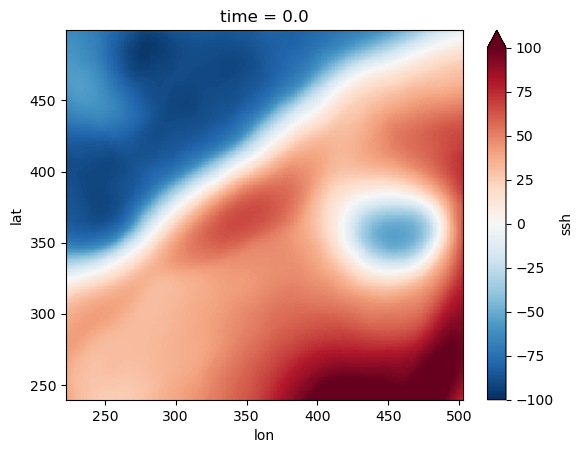

In [12]:
fscale = 10
nh = 12
if fscale > 0.:
    dsh = xr.open_zarr(
        '/tank/spectre/tuchida/SWOT/Models/HYCOM50/SSH_%02dkm.zarr'
        % fscale
    ).isel(lat=slice(240,500),lon=slice(-280,None))
    SSH = dsh.ssh.isel(time=np.arange(0,len(dsh.time),nh))
else:
    SSH = hycom01s.ssh.isel(time=np.arange(0,len(hycom01s.time),nh),
                            lat=slice(240,500),lon=slice(-280,None))
    SSH = SSH - SSH.mean(['lat','lon'])
SSH = SSH.assign_coords({'time':np.arange(len(SSH.time)) * 3600.*nh})
SSH.isel(time=0).plot(rasterized=True, vmax=100)

hycom_grid = xr.open_dataset(
    '/tank/spectre/tuchida/SWOT/Models/HYCOM50/HYCOM50_grid_GS_all.nc'
                            ).isel(lat=slice(240,500),lon=slice(-280,None))
hycom_grid

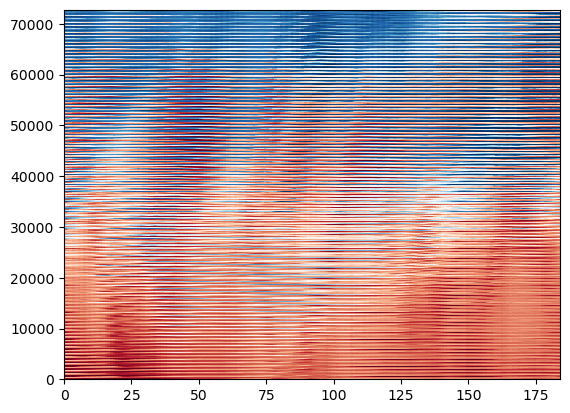

<xarray.DataArray 'ssh' (z: 72800, time: 184)>
dask.array<transpose, shape=(72800, 184), dtype=float32, chunksize=(1750, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 4.32e+04 8.64e+04 ... 7.862e+06 7.906e+06
  * z        (z) object MultiIndex
  * lat      (z) int64 240 240 240 240 240 240 240 ... 499 499 499 499 499 499
  * lon      (z) int64 223 224 225 226 227 228 229 ... 497 498 499 500 501 502

In [13]:
zchunk = 1750
# h_stacked = SSH.stack(z=("lat","lon")).chunk({'z':zchunk})
h_stacked = SSH.stack(z=("lat","lon")).chunk({'z':zchunk})
# t_stacked = SST.stack(z=("lat","lon")).chunk({'z':zchunk})
# s_stacked = SSS.stack(z=("lat","lon")).chunk({'z':zchunk})
# u_stacked = hycom01s.uu1.stack(z=("lat","lon")).chunk({'z':zchunk})
# v_stacked = hycom01s.vv1.stack(z=("lat","lon")).chunk({'z':zchunk})
# hts = xr.concat([xr.concat([h_stacked.drop("z")/ampH, 
#                             t_stacked.drop("z")/ampT
#                            ], dim="z"), 
#                  s_stacked.drop("z")/ampS
#                 ], dim='z')

fig, ax = plt.subplots()
ax.pcolormesh(SSH.stack(z=("lat","lon")).chunk({'z':zchunk}).T.values, 
              rasterized=True, vmax=100, vmin=-100, cmap='RdBu_r')
plt.show()
h_stacked.T

In [23]:
# # window_lengths = np.array([8, 16, 64, 240])
# # step_sizes = np.array([1, 1, 2, 16])
# window_lengths = (np.array([24, 48, 192, 720]) / nh).astype(int)     # 3 hourly
# step_sizes = np.array([1, 1, 2, 16])
# # window_lengths = np.array([8, 16, 28, 72, 240])
# # step_sizes = np.array([1, 2, 2, 4, 16])
# window_lengths = (np.array([24, 48, 84, 216, 720]) / nh).astype(int) # 3 hourly
# step_sizes = np.array([1, 2, 2, 4, 16])
window_lengths = (np.array([96, 192, 720]) / nh).astype(int)           # 12 hourly
step_sizes = np.array([2, 4, 16])
window_lengths, window_lengths*(nh*3600)/86400

(array([ 8, 16, 60]), array([ 4.,  8., 30.]))

In [19]:
fit = True

In [24]:
# window_lengths = [15, 60]
# step_sizes = [1, 12]
# step_sizes = (window_lengths * .07).astype(int)
sr = 6
svd_ranks = [sr] * len(window_lengths)
suppress_growth = True
transform_method = "absolute"
# n_components_array = [2] * len(window_lengths)
global_svd_array = [False] * len(window_lengths)

dmd = mrCOSTS(
    svd_rank_array=svd_ranks,
    window_length_array=window_lengths,
    step_size_array=step_sizes,
    global_svd_array=global_svd_array,
    cluster_sweep=True,
    transform_method=transform_method,
    # pydmd_kwargs={'eig_constraints':{"imag", "conjugate_pairs"}},
    # n_components_array=n_components_array,
)

if fit:
    dmd.fit(h_stacked.values.T, 
            np.atleast_2d(h_stacked.time.data)
           )

_________________________________________________
Fitting window length = 8
0 of 89
50 of 89
Error in Global Reconstruction = 0.021
_________________________________________________
Fitting window length = 16
0 of 43
Error in Global Reconstruction = 0.024
_________________________________________________
Fitting window length = 60
0 of 9
Error in Global Reconstruction = 0.066


In [26]:
if fit:
    dmd.to_netcdf(op.join(sdir, 
                          "HYCOM50/ASO/mrCOSTS_h/%02dhourly/%02d_fit"
                          % (nh,len(window_lengths))
                         )
                 )
else:
    mrc = glob.glob(op.join(sdir, 
                            "HYCOM50/ASO/mrCOSTS_h/%02dhourly/%02d_fit*.nc"
                            % (nh,len(window_lengths))
                           )
                   )
    print(mrc)
    dmd = mrCOSTS()
    dmd.from_netcdf(mrc)

In [27]:
# Plot the 3rd decomposition level
n_decomp = 2
mrd = dmd.costs_array[n_decomp]

# The data for each decomposition level is built here to avoid
# reconstructing the data for each plot. If this is not done the
# plots can still be rendered but will take slightly longer.
if n_decomp == 0:
    x_iter = data
else:
    x_iter, _ = dmd.costs_array[n_decomp - 1].scale_separation(
        scale_reconstruction_kwargs=dmd._costs_recon_kwargs
    )

Text(0.5, 0.98, 'Window length=60')

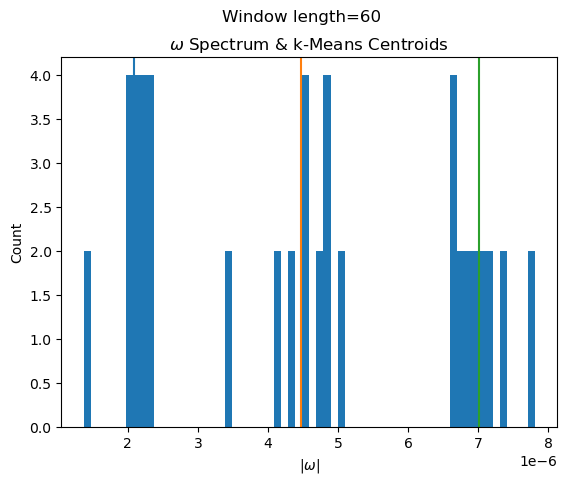

In [28]:
fig, ax = mrd.plot_omega_histogram()
fig.suptitle("Window length={}".format(mrd.window_length))

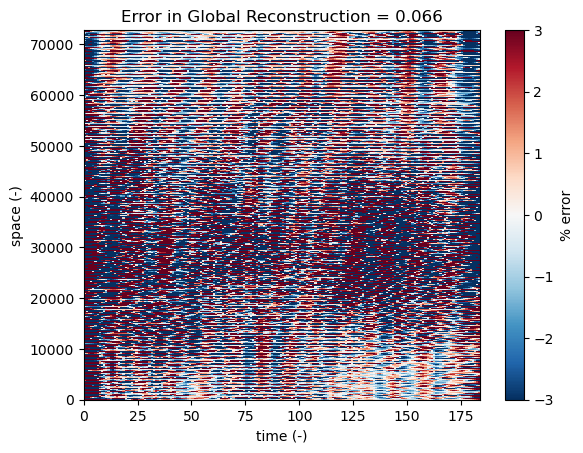

In [29]:
# Error in global reconstruction
dmd.plot_local_error(
    n_decomp, data=x_iter, scale_reconstruction_kwargs=dmd._costs_recon_kwargs
)

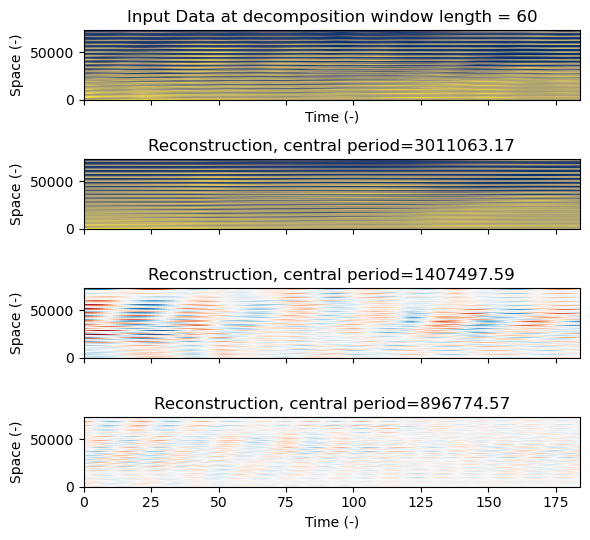

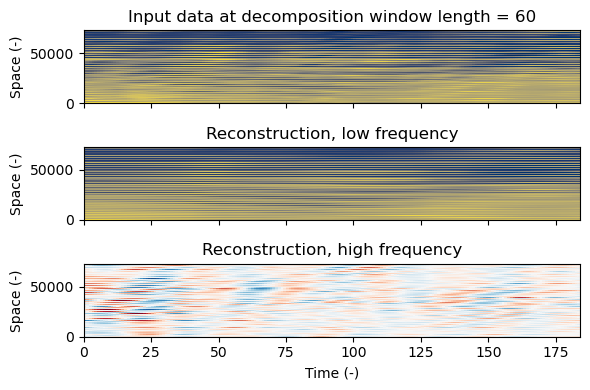

In [30]:
# Scale separation
_ = dmd.plot_local_reconstructions(
    n_decomp,
    data=x_iter,
    kwargs={"plot_period": True},
    scale_reconstruction_kwargs=dmd._costs_recon_kwargs,
)

# Alternatively you can use the local scale separation to visualize the individual frequency bands
# seen in the eigenvalue histogram.
_ = dmd.plot_local_scale_separation(
    n_decomp, data=x_iter, scale_reconstruction_kwargs=dmd._costs_recon_kwargs
)

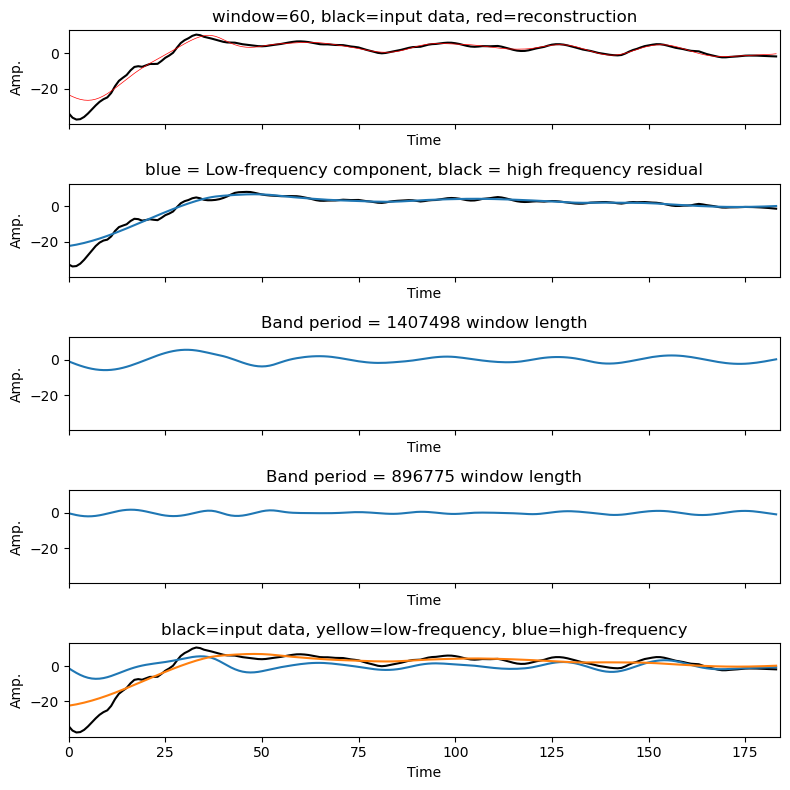

In [31]:
# Single points in space
space_index = 40
_, _ = dmd.plot_local_time_series(
    space_index,
    n_decomp,
    x_iter,
    scale_reconstruction_kwargs=dmd._costs_recon_kwargs,
)

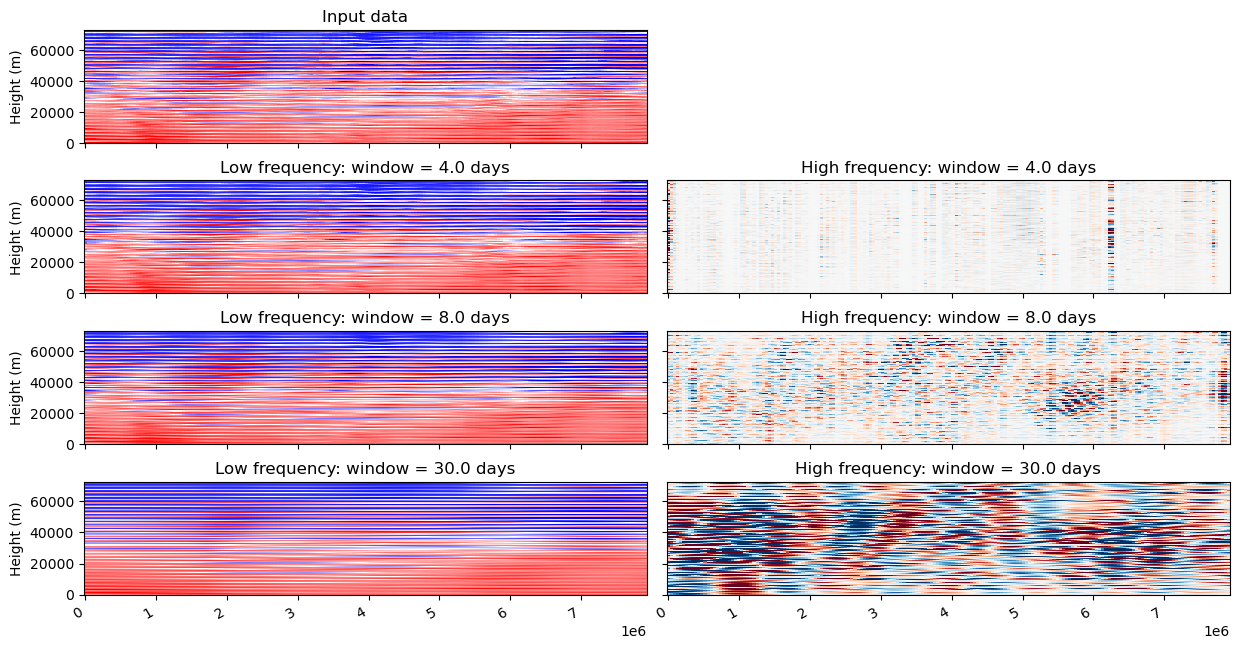

In [32]:
vscale = 10
fig, axes = plt.subplots(
    dmd.n_decompositions + 1,
    2,
    figsize=(6.25*2, dmd.n_decompositions * 1.25*2),
    sharex=True,
    sharey=True,
)

plot_kwargs = {
    "cmap": "RdBu_r",
    "vmin": -vscale,
    "vmax": vscale,
}

plot_kwargs_lf = {
    "cmap": "bwr",
    "vmin": -100,
    "vmax": 100,
}

ax = axes[0, 0]
ax.pcolormesh(h_stacked.time.values, np.arange(len(h_stacked.z)), h_stacked.T, **plot_kwargs_lf)
ax.set_title("Input data")
ax.set_ylabel("Height (m)")

axes[0, 1].axis("off")
for nm, m in enumerate(dmd.costs_array):
    xr_low_frequency, xr_high_frequency = m.scale_separation()

    ax = axes[nm + 1, 1]
    ax.pcolormesh(
        h_stacked.time.values, np.arange(len(h_stacked.z)), 
        xr_high_frequency, **plot_kwargs
    )
    ax.set_title(
        "High frequency: window = {} days".format(m._window_length*nh*3600./86400.))

    ax = axes[nm + 1, 0]
    ax.pcolormesh(
        h_stacked.time.values, 
        np.arange(len(h_stacked.z)),
        xr_low_frequency,
        **plot_kwargs_lf
    )
    ax.set_title(
        "Low frequency: window = {} days".format(m._window_length*nh*3600./86400.))
    ax.set_ylabel("Height (m)")

# axes[-1, 0].xaxis.set_major_formatter(DateFormatter("%H:%M"))

fig.tight_layout()
fig.autofmt_xdate()